In [1]:
## Steps to perform:
### 1.  Create RFM analysis:
### ### A) Create Cohort_Analysis
### ### ### ### Cohort_Month(funkcja + kolumna (1 dzien miesiaca))              done
### ### ### ### Cohort_Index (od 1 kohorty do ostatniej)                        done
### ### ### ### Cohort HeatMap                               started _ to be fixed (kolory, etykiety + przemysl 2 spojrzenia)
### ### B) Calculate RFM values                                                done (check if adjust to last 6M,12M,3M)

### ### C) Assign RFM classes as per values (from finger or Clustering)
### 2.  Analyze data as per 'returnQuantity'
#  
#
#
#
#
#
### 3.  Perform Feature Engineering
### ### A) RETURN two strategies: (1: if return 2: how big return) vs (poisson / other rozklad)
### ### B) Analyses to be created:
### ### ### ### 1. Customer analyzes (how many categories per purchase, how many in total,
### ### ### ### ### ### ### ### spend% per category, how often vouchers (out of all visits)
### ### ### ### ### ### ### ### vouchered_amount / total_spend, how many products per purchase, how many items per basket.
### ### ### ### 2. Basket analyzes (how many categories in basket, how many items in one category)
### ### ### ### ### ### ### ###
### ### ### ### 3. Products mixes (calculating substitutity/complementary): co z czym się kupuje....
### ### ### ### ### ### ### ###
## Questions to answer:
#### If buying more the same items but in different sizes/color (to match size)
#### If buying more the same category in basket: increase prob or return
### ### C) Possible variabales in Feat. Eng.:
### ### ### ### Discount Perctg (price / recom)
### ### ### ### If this purchase has 1 or few categories
### ### ### ### If this customer buys 1 or few categories
### ### ### ### If any products mix available( with top prob of return)
### 4.  Modeling:
### ### A) Creating basic model: very very basic (random or linear regression with basic variables (ininital dataset))
### ### B) Adding new features to model (FE, etc, one-hot-encoding)
### ### C) LR, DTr, RF, etc, Deep Learning

In [2]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv('orders_train.txt', sep=';')
train['orderDate'] = pd.to_datetime(train['orderDate'])

In [4]:
imp_col = ['orderID', 'articleID','voucherID','customerID']
for each in imp_col:
    print(train[each].nunique(),"\t\t",each)

738698 		 orderID
3823 		 articleID
670 		 voucherID
311369 		 customerID


In [5]:
train['spend'] = train['quantity'] * train['price']
train['rrp_spend'] = train['quantity'] * train['rrp']
train['return_spend'] = train['returnQuantity'] * train['spend']
train['price_decrease'] = train['price'] / train['rrp'] -1
train['returny'] = np.where(train['returnQuantity']==0, 'not returned', 'returned')


In [6]:
pd.crosstab(train.productGroup, train.returny, normalize = 'index').round(2).T

productGroup,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,13.0,14.0,15.0,17.0,26.0,43.0,45.0,50.0,90.0
returny,,,,,,,,,,,,,,,,,,
not returned,0.41,0.42,0.54,0.49,0.46,0.49,0.38,0.42,0.4,0.32,0.38,0.47,0.62,1.0,0.86,0.9,0.38,0.81
returned,0.59,0.58,0.46,0.51,0.54,0.51,0.62,0.58,0.6,0.68,0.62,0.53,0.38,0.0,0.14,0.1,0.62,0.19


In [7]:
pd.crosstab(train.paymentMethod, train.returny, normalize = 'index').round(2).T

paymentMethod,BPLS,BPPL,BPRG,CBA,KGRG,KKE,NN,PAYPALVC,RG,VORAUS
returny,,,,,,,,,,
not returned,0.63,0.59,0.44,0.63,0.71,0.55,0.66,0.61,1.0,0.63
returned,0.37,0.41,0.56,0.37,0.29,0.45,0.34,0.39,0.0,0.37


In [8]:
pd.crosstab(train.deviceID, train.returny, normalize = 'index').round(2).T

deviceID,1,2,3,4,5
returny,,,,,
not returned,0.36,0.48,0.49,0.46,0.47
returned,0.64,0.52,0.51,0.54,0.53


In [9]:
colors = pd.crosstab(train.colorCode, train.returny, normalize = 'index').returned > 60
colors.reset_index()

,colorCode,returned
0,1000,False
1,1001,False
2,1002,False
3,1003,False
4,1004,False
...,...,...
541,7204,False
542,7205,False
543,7215,False
544,7216,False


In [10]:
pd.crosstab(train.colorCode, train.returny, normalize = 'index').round(2).T

colorCode,1000,1001,1002,1003,1004,1007,1008,1009,1010,1011,...,7196,7200,7201,7202,7203,7204,7205,7215,7216,8888
returny,,,,,,,,,,,,,,,,,,,,,
not returned,0.52,0.47,0.46,0.47,0.53,0.46,0.44,0.36,0.51,0.56,...,0.37,0.43,0.47,0.36,0.32,0.43,0.44,0.33,0.64,0.9
returned,0.48,0.53,0.54,0.53,0.47,0.54,0.56,0.64,0.49,0.44,...,0.63,0.57,0.53,0.64,0.68,0.57,0.56,0.67,0.36,0.1


In [11]:
train.groupby(['returny']).price_decrease.count()

returny
not returned    1103202
returned        1206407
Name: price_decrease, dtype: int64

In [12]:
# basket data
# 
train.groupby('orderID').agg({'articleID':'nunique','productGroup':'nunique',\
                              'spend':'sum','rrp':'mean','rrp_spend':'sum','quantity':'sum',\
                              'voucherID':'nunique','voucherAmount':'sum',\
                              'returnQuantity':'sum','return_spend':'sum'}).round(2)

,articleID,productGroup,spend,rrp,rrp_spend,quantity,voucherID,voucherAmount,returnQuantity,return_spend
orderID,,,,,,,,,,
a1000001,2,1,30.00,34.99,69.98,2,1,0.0,0,0.00
a1000002,2,1,84.99,49.99,99.98,2,1,0.0,1,49.99
a1000003,4,2,60.00,42.39,151.96,4,1,0.0,0,0.00
a1000004,1,1,89.99,89.99,89.99,1,1,0.0,1,89.99
a1000005,2,1,35.00,33.32,99.97,3,1,0.0,3,35.00
...,...,...,...,...,...,...,...,...,...,...
a3468747,1,1,28043.21,25.99,1897.27,73,1,0.0,0,0.00
a3468750,1,1,459.98,229.99,459.98,2,1,0.0,0,0.00
a3468752,1,0,10.00,NaN,0.00,1,1,0.0,0,0.00


In [13]:
# customer data

In [14]:
cust = train.groupby('customerID').agg({'orderID':'nunique','productGroup':'nunique','articleID':'nunique',\
                              'quantity':'sum','returnQuantity':'sum',\
                               'colorCode':'nunique', 'sizeCode':'nunique'}).round(2)

cust['returnrate'] = cust.returnQuantity/cust.quantity
cust.sample(5)

,orderID,productGroup,articleID,quantity,returnQuantity,colorCode,sizeCode,returnrate
customerID,,,,,,,,
c1157713,1,2,8,11,8,6,1,0.727273
c1140119,7,5,15,25,22,16,3,0.880000
c1126211,2,2,2,3,0,3,2,0.000000
c1230250,3,2,3,5,2,3,3,0.400000
c1265694,2,2,2,2,2,2,2,1.000000


In [15]:
prod_gr = train.groupby('productGroup').agg({'orderID':'nunique',\
                              'quantity':'sum','returnQuantity':'sum',\
                               'colorCode':'nunique', 'sizeCode':'nunique'}).round(2)

prod_gr['returnrate'] = prod_gr.returnQuantity/prod_gr.quantity
prod_gr.sample(5)

,orderID,quantity,returnQuantity,colorCode,sizeCode,returnrate
productGroup,,,,,,
43.0,2882,2884,405,1,1,0.140430
90.0,31,31,6,1,1,0.193548
14.0,35855,44486,27950,66,6,0.628288
50.0,7089,8066,5077,22,6,0.629432
15.0,9045,10847,5860,34,6,0.540242


In [16]:
train.sample(4)

,orderID,orderDate,articleID,colorCode,sizeCode,productGroup,quantity,price,rrp,voucherID,voucherAmount,customerID,deviceID,paymentMethod,returnQuantity,spend,rrp_spend,return_spend,price_decrease,returny
1536364,a1498295,2015-03-26,i1001866,1001,42,8.0,1,25.00,49.99,v1000415,10.0,c1195748,2,PAYPALVC,1,25.00,49.99,25.00,-0.499900,returned
426572,a1139328,2014-05-15,i1000365,1854,44,3.0,1,15.99,15.99,0,0.0,c1013292,3,BPRG,1,15.99,15.99,15.99,0.000000,returned
2075635,a1666862,2015-07-30,i1001127,1493,44,3.0,1,10.00,35.99,v1000415,10.0,c1257729,2,BPRG,1,10.00,35.99,10.00,-0.722145,returned
1241741,a1399419,2014-12-27,i1002485,1001,44,14.0,1,65.00,89.99,0,0.0,c1221550,5,BPRG,1,65.00,89.99,65.00,-0.277698,returned


In [17]:
# product data


In [18]:
prod = train.groupby('articleID').agg({'orderID':'nunique','voucherID':'nunique',\
                              'quantity':'sum','returnQuantity':'sum',\
                               'colorCode':'nunique', 'sizeCode':'nunique'}).round(2)

prod['returnrate'] = prod.returnQuantity/prod.quantity
prod.sample(5)

,orderID,voucherID,quantity,returnQuantity,colorCode,sizeCode,returnrate
articleID,,,,,,,
i1001812,670,22,800,650,3,6,0.812500
i1003758,455,30,513,260,2,7,0.506823
i1001051,506,18,571,306,2,6,0.535902
i1000719,567,21,656,373,4,6,0.568598
i1000946,133,12,128,53,1,6,0.414062


In [19]:
train.groupby(['articleID']).colorCode.nunique().sort_values(ascending = False)

articleID
i1003278    36
i1003279    32
i1000398    27
i1000315    27
i1000397    24
            ..
i1002437     1
i1002436     1
i1002431     1
i1002430     1
i1000003     1
Name: colorCode, Length: 3823, dtype: int64

In [20]:
train.sample(5)

,orderID,orderDate,articleID,colorCode,sizeCode,productGroup,quantity,price,rrp,voucherID,voucherAmount,customerID,deviceID,paymentMethod,returnQuantity,spend,rrp_spend,return_spend,price_decrease,returny
2030152,a1652359,2015-07-17,i1000670,1493,38,3.0,1,9.99,9.99,0,0.0,c1001723,2,BPRG,0,9.99,9.99,0.00,0.000000,not returned
811961,a1255048,2014-08-14,i1001926,1010,40,8.0,1,25.00,49.99,0,0.0,c1007791,2,CBA,1,25.00,49.99,25.00,-0.499900,returned
2047089,a1657773,2015-07-22,i1001084,1089,42,3.0,1,12.00,17.99,0,0.0,c1296436,3,BPRG,1,12.00,17.99,12.00,-0.332963,returned
47499,a1015767,2014-01-18,i1000244,6784,29,2.0,1,69.99,69.99,0,0.0,c1034311,2,BPRG,0,69.99,69.99,0.00,0.000000,not returned
1195910,a1383581,2014-12-09,i1000990,1012,38,3.0,1,27.99,27.99,0,0.0,c1121686,2,BPRG,1,27.99,27.99,27.99,0.000000,returned


In [21]:
## ## ## returnQuantity   vs:
#  payment method
#  device
#  ilosc rzeczy w koszyku
#  ColorCode
#  if rebate_m
# if 

## ## ## returnQuantity   vs:
# BlackFriday ? other promo days: Check Discount Rate Promo (Globalna skala na kalendarzu)

In [22]:
pd.crosstab(train.productGroup, train.returnQuantity, normalize = 'index').round(3)

returnQuantity,0,1,2,3,4,5
productGroup,,,,,,
1.0,0.405,0.594,0.001,0.0,0.0,0.0
2.0,0.419,0.579,0.002,0.0,0.0,0.0
3.0,0.539,0.459,0.002,0.0,0.0,0.0
4.0,0.487,0.512,0.001,0.0,0.0,0.0
5.0,0.458,0.541,0.001,0.0,0.0,0.0
6.0,0.487,0.512,0.001,0.0,0.0,0.0
7.0,0.377,0.622,0.001,0.0,0.0,0.0
8.0,0.417,0.581,0.002,0.0,0.0,0.0
9.0,0.404,0.595,0.001,0.0,0.0,0.0


In [23]:
def get_firt_tran_month(x):
    return dt.datetime(x.year, x.month, 1)

def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    #day = df[column].dt.day
    return year, month

In [38]:
dates = train.groupby(['customerID']).orderDate.min().reset_index()
dates['CohortMonth'] = dates['orderDate'].apply(get_firt_tran_month)
dates.sample(5)

,customerID,orderDate,CohortMonth
238260,c1245895,2015-03-15,2015-03-01
99331,c1106295,2014-02-22,2014-02-01
121396,c1128472,2014-04-18,2014-04-01
72396,c1077379,2015-01-18,2015-01-01
5838,c1006166,2014-09-22,2014-09-01


In [39]:
coh_train = pd.merge(train, dates[['customerID','CohortMonth']], on = ['customerID'], how='inner')

In [40]:
# Get the integers for date parts from the `InvoiceDay` column
trans_year, trans_month = get_date_int(coh_train,'orderDate')
# Get the integers for date parts from the `CohortDay` column
cohort_year, cohort_month = get_date_int(coh_train,'CohortMonth')

# Calculate difference in years
years_diff = trans_year - cohort_year
# Calculate difference in months
months_diff = trans_month - cohort_month

# Extract the difference in days from all previous values
coh_train['CohortIndex'] = years_diff * 12 + months_diff + 1
coh_train.head()

,orderID,orderDate,articleID,colorCode,sizeCode,productGroup,quantity,price,rrp,voucherID,...,deviceID,paymentMethod,returnQuantity,spend,rrp_spend,return_spend,price_decrease,returny,CohortMonth,CohortIndex
0,a1000001,2014-01-01,i1000382,1972,44,3.0,1,10.0,29.99,0,...,2,BPRG,0,10.0,29.99,0.0,-0.666556,not returned,2014-01-01,1
1,a1000001,2014-01-01,i1000550,3854,44,3.0,1,20.0,39.99,0,...,2,BPRG,0,20.0,39.99,0.0,-0.499875,not returned,2014-01-01,1
2,a1155949,2014-05-27,i1000579,3974,44,3.0,1,9.0,29.99,0,...,2,BPRG,0,9.0,29.99,0.0,-0.699900,not returned,2014-01-01,5
3,a1155949,2014-05-27,i1000629,1894,44,3.0,1,18.0,35.99,0,...,2,BPRG,0,18.0,35.99,0.0,-0.499861,not returned,2014-01-01,5
4,a1000002,2014-01-01,i1001991,2974,38,8.0,1,35.0,49.99,0,...,4,BPRG,0,35.0,49.99,0.0,-0.299860,not returned,2014-01-01,1


In [97]:
grouping = coh_train.groupby(['CohortMonth', 'CohortIndex'])

# Count the number of unique values per customer ID
cohort_data = grouping['customerID'].apply(pd.Series.nunique).reset_index()
# Create a pivot 
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='customerID')
# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]
# Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3)

CohortIndex,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2014-01-01,1.0,0.186,0.176,0.172,0.192,0.181,0.157,0.143,0.140,0.160,...,0.117,0.136,0.126,0.148,0.133,0.136,0.128,0.120,0.115,0.116
2014-02-01,1.0,0.136,0.128,0.140,0.145,0.119,0.110,0.110,0.121,0.101,...,0.097,0.090,0.109,0.099,0.103,0.098,0.090,0.085,0.085,NaN
2014-03-01,1.0,0.121,0.118,0.130,0.096,0.095,0.093,0.100,0.081,0.065,...,0.077,0.098,0.085,0.088,0.086,0.074,0.069,0.074,NaN,NaN
2014-04-01,1.0,0.110,0.111,0.084,0.083,0.080,0.089,0.066,0.055,0.061,...,0.080,0.074,0.078,0.070,0.062,0.057,0.056,NaN,NaN,NaN
2014-05-01,1.0,0.114,0.085,0.075,0.076,0.085,0.068,0.053,0.057,0.057,...,0.064,0.076,0.070,0.061,0.056,0.054,NaN,NaN,NaN,NaN
2014-06-01,1.0,0.094,0.070,0.066,0.079,0.064,0.048,0.052,0.050,0.065,...,0.065,0.068,0.062,0.054,0.048,NaN,NaN,NaN,NaN,NaN
2014-07-01,1.0,0.079,0.063,0.067,0.065,0.055,0.051,0.049,0.065,0.055,...,0.060,0.060,0.054,0.048,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-01,1.0,0.084,0.072,0.063,0.057,0.057,0.055,0.069,0.061,0.060,...,0.056,0.055,0.049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-01,1.0,0.083,0.063,0.051,0.056,0.062,0.070,0.057,0.061,0.063,...,0.046,0.053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


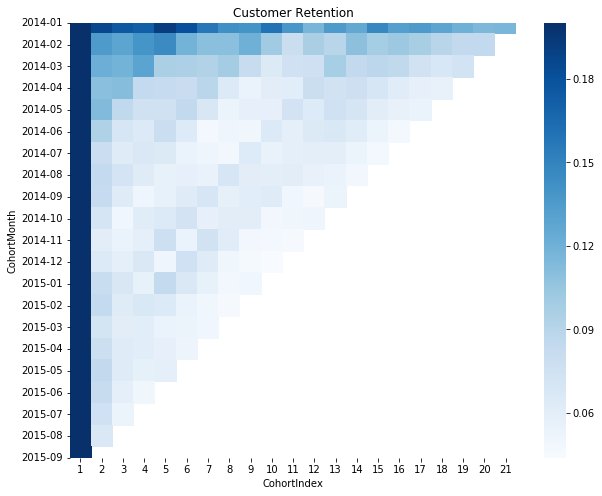

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(10, 8))
# Add a title
plt.title('Customer Retention')
# Create the heatmap
ax = sns.heatmap(retention, annot=False, cmap='Blues', vmax = 0.2)
ax.set_yticklabels(retention.index.strftime('%Y-%m'),fontdict = {'verticalalignment': 'center'})
plt.show()

## Popraw :
#max skali (by maks kolor juz dla 50%
#etykiety danych z lewej strony (idealnie: rok i miesiac)

In [27]:
coh_train.sample(4)

,orderID,orderDate,articleID,colorCode,sizeCode,productGroup,quantity,price,rrp,voucherID,voucherAmount,customerID,deviceID,paymentMethod,returnQuantity,spend,price_decrease,CohortMonth,CohortIndex
534624,a1231962,2014-07-26,i1003744,1854,44,1.0,1,39.99,39.99,0,0.0,c1077594,3,BPRG,0,39.99,0.000000,2014-02-01,6
660456,a1419014,2015-01-19,i1001187,1033,36,4.0,1,29.99,29.99,0,0.0,c1108833,2,BPRG,1,29.99,0.000000,2014-03-01,11
1940135,a1639907,2015-07-07,i1001125,1003,40,3.0,1,20.00,39.99,0,0.0,c1237761,2,BPRG,1,20.00,-0.499875,2015-02-01,6
600970,a1484702,2015-03-15,i1001024,1940,38,3.0,1,25.00,49.99,v1000476,10.0,c1029463,2,BPRG,1,25.00,-0.499900,2014-02-01,14


In [29]:
today = train['orderDate'].max()

# Calculate Recency, Frequency and Monetary value for each customer 
data_tran = coh_train.groupby(['customerID']).agg({
    'orderDate': lambda x: (today - x.max()).days,
    'orderID': 'count',
    'spend': 'sum'})

# Rename the columns 
data_tran.rename(columns={'orderDate': 'Recency',
                         'orderID': 'Frequency',
                         'spend': 'MonetaryValue'}, inplace=True)

# Print top 5 rows
print(data_tran.head())

            Recency  Frequency  MonetaryValue
customerID                                   
c1000001          9        186        5123.39
c1000002        327         15         859.86
c1000003        336          5         175.97
c1000004         77          9         251.92
c1000005         30         89        3579.26


In [74]:
def calc_association(data,var = 'productGroup'):
    grouping = data[['productGroup','articleID','orderID','quantity']].groupby(['orderID',var]).quantity.sum().reset_index()
    grouping.columns = ['orderID',var,'check']
    grouping = grouping.sort_values('check', ascending = False)
    grouping['check'] = 1
    
    if var == 'articleID':
        grouping = grouping.head(500)
    
    group_piv = grouping.pivot(columns=grouping.columns[1],index='orderID',values='check').fillna(0)
    prod = round(pd.DataFrame(np.dot(group_piv.iloc[:,1:].T,group_piv.iloc[:,1:]))/group_piv.shape[0],4)
    
    table = []
    
    i = 0
    
    for c in range(len(prod.columns)):
        for r in range(c,len(prod.columns)):
            
            prod_aa = group_piv.columns[r]
            prod_bb = group_piv.columns[c]
            prob_aa = prod.iloc[r,r]
            prob_ab = prod.iloc[r,c]
            prob_bb = prod.iloc[c,c]
            
            likeliness = prob_ab / prob_aa
            association = prob_ab / (prob_aa * prob_bb)
    
            table.append([prod_aa,prod_bb,prob_aa,prob_ab,prob_bb,likeliness,association])
        
            tab1 = pd.DataFrame(table)
            tab1.columns = ['prod_aa','prod_bb','prob_aa','prob_ab','prob_bb','likeliness','association']
            tab1 = tab1[tab1['prod_aa'] != tab1['prod_bb']]
            tab2 = tab1.sort_values('association', ascending= False)
    return tab2.style.format({'prob_aa':'{:.2%}','prob_ab':'{:.2%}','prob_bb':'{:.2%}','likeliness':'{:.2%}','association':'{:.2}'})

In [72]:
calc_association(train,var='productGroup')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


,prod_aa,prod_bb,prob_aa,prob_ab,prob_bb,likeliness,association
145,45,26,0.96%,0.01%,0.39%,1.04%,2.7
128,26,14,0.39%,0.01%,1.22%,2.56%,2.1
99,9,8,8.87%,1.22%,6.87%,13.75%,2.0
80,14,6,1.22%,0.10%,4.41%,8.20%,1.9
123,45,13,0.96%,0.08%,4.86%,8.33%,1.7
34,4,3,8.28%,1.27%,10.25%,15.34%,1.5
68,14,5,1.22%,0.07%,3.87%,5.74%,1.5
135,43,15,1.66%,0.35%,14.48%,21.08%,1.5
35,5,3,3.87%,0.57%,10.25%,14.73%,1.4
56,15,4,14.48%,1.70%,8.28%,11.74%,1.4


In [ ]:
calc_association(train,var='articleID')

In [36]:
train[(train['returnQuantity']>1)&(train['quantity']!=train['returnQuantity'])]

,orderID,orderDate,articleID,colorCode,sizeCode,productGroup,quantity,price,rrp,voucherID,voucherAmount,customerID,deviceID,paymentMethod,returnQuantity,count
4307,a1001513,2014-01-03,i1000526,2976,36,3.0,5,100.00,29.99,0,0.0,c1089966,3,CBA,4,1
5785,a1002010,2014-01-04,i1000312,1000,38,3.0,5,89.95,17.99,0,0.0,c1090173,2,PAYPALVC,2,0
32624,a1010973,2014-01-14,i1000321,1493,38,3.0,4,103.96,25.99,0,0.0,c1093258,2,BPRG,2,2
37902,a1012696,2014-01-15,i1000526,2976,42,3.0,3,60.00,29.99,0,0.0,c1093834,2,BPRG,2,0
42892,a1014236,2014-01-17,i1000325,1000,40,3.0,3,59.97,19.99,v1000078,10.0,c1044371,2,BPRG,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280187,a1729833,2015-09-18,i1002605,1082,I,17.0,4,134.44,39.99,0,0.0,c1283475,3,BPLS,3,51
2280188,a1729833,2015-09-18,i1002611,3111,I,17.0,5,117.60,27.99,0,0.0,c1283475,3,BPLS,2,52
2288881,a1732544,2015-09-21,i1002953,2089,I,17.0,3,21.00,22.99,v1000737,10.0,c1316465,2,BPRG,2,11
2290518,a1733111,2015-09-21,i1000397,1111,42,3.0,3,53.97,17.99,0,0.0,c1055271,3,BPRG,2,72


In [37]:
train.sizeCode.value_counts()

38     395163
40     393547
42     393244
44     359473
36     270462
34     147173
I      116374
A       42014
32      36554
29      30560
30      29115
31      26133
28      22634
33      20890
27      17139
26       9836
25       5104
85       1680
90       1613
95       1597
80       1157
100      1059
M         751
75        491
L         445
S         444
24        317
XL        158
XS         38
Name: sizeCode, dtype: int64

In [34]:
train['count'] = train.groupby(['customerID']).cumcount()
#train.sort_values(['customerID','orderDate'],ascending = [False,False])
first_order = train[train['count'] == 0][['customerID','orderDate']]
first_order.columns = ['customerID','f_order']
first_order.head()

,customerID,f_order
0,c1010575,2014-01-01
2,c1045905,2014-01-01
4,c1089295,2014-01-01
9,c1050116,2014-01-01
10,c1089296,2014-01-01


In [ ]:
pd.crosstab(train.paymentMethod, train.returnQuantity, normalize = 'index').round(3).sort_values(0,ascending = False)

In [14]:
pd.crosstab(train.productGroup, train.returnQuantity, normalize = 'index').round(3)

returnQuantity,0,1,2,3,4,5
productGroup,,,,,,
1.0,0.405,0.594,0.001,0.0,0.0,0.0
2.0,0.419,0.579,0.002,0.0,0.0,0.0
3.0,0.539,0.459,0.002,0.0,0.0,0.0
4.0,0.487,0.512,0.001,0.0,0.0,0.0
5.0,0.458,0.541,0.001,0.0,0.0,0.0
6.0,0.487,0.512,0.001,0.0,0.0,0.0
7.0,0.377,0.622,0.001,0.0,0.0,0.0
8.0,0.417,0.581,0.002,0.0,0.0,0.0
9.0,0.404,0.595,0.001,0.0,0.0,0.0


In [7]:
train.shape

(2325165, 15)

In [17]:
final = pd.read_csv('orders_class.txt', sep=';')
final.head()

,orderID,orderDate,articleID,colorCode,sizeCode,productGroup,quantity,price,rrp,voucherID,voucherAmount,customerID,deviceID,paymentMethod
0,a1744178,2015-10-01,i1002632,3097,I,17.0,1,19.99,19.99,v1000415,10.0,c1062117,2,BPRG
1,a1744178,2015-10-01,i1003278,1097,40,3.0,1,12.95,12.95,v1000415,10.0,c1062117,2,BPRG
2,a1744178,2015-10-01,i1003279,1114,40,3.0,1,12.95,12.95,v1000415,10.0,c1062117,2,BPRG
3,a1744178,2015-10-01,i1003279,1116,40,3.0,1,12.95,12.95,v1000415,10.0,c1062117,2,BPRG
4,a1744178,2015-10-01,i1003279,1117,40,3.0,1,12.95,12.95,v1000415,10.0,c1062117,2,BPRG


In [18]:
final['orderDate'].min(), final['orderDate'].max()

('2015-10-01', '2015-12-31')

In [39]:
final.quantity.value_counts()

1    331590
0      6692
2      2512
3       211
5        52
4        41
Name: quantity, dtype: int64

## Train file

In [ ]:
# Create model

clf = DecisionTreeClassifier()

 

# Set up k-fold

k_fold = KFold(n_splits = 4, random_state = 0)

 

# Evaluate precision and recall for each fold

precision = cross_val_score(

  clf, X_train, y_train, cv = k_fold, scoring = 'precision_weighted')

recall = cross_val_score(

  clf, X_train, y_train, cv = k_fold, scoring = 'recall_weighted')

print("Precision scores: %s" %(precision))

print("Recall scores: %s" %(recall))